In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_217bc86399661a10f56435977bcbf87a"


In [ ]:
import os, json

kaggle_creds = {
    "username": "iroonman",
    "key": "KGAT_217bc86399661a10f56435977bcbf87a"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.kaggle/kaggle.json", 600)

print("kaggle.json created successfully")


kaggle.json created successfully


In [ ]:
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
License(s): CC0-1.0
car-plate-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  car-plate-detection.zip
replace annotations/Cars0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip -n car-plate-detection.zip


Archive:  car-plate-detection.zip


In [ ]:
!rm car-plate-detection.zip

In [ ]:
!ls

 annotations	 'car (1).jpg'	 car.jpg     runs
 bus.jpg	  car1.png	 data	     sample_data
'car1 (1).heic'  'car (2).jpg'	 dataset     vehicle-detection-image-set.zip
'car1 (1).png'	 'car (3).jpg'	 data.yaml   yolo26n.pt
 car1.heic	  car.heic	 images      yolov8n.pt


In [ ]:
!rm vehicle-detection-image-set.zip


In [ ]:
!ls annotations | head


Cars0.xml
Cars100.xml
Cars101.xml
Cars102.xml
Cars103.xml
Cars104.xml
Cars105.xml
Cars106.xml
Cars107.xml
Cars108.xml


In [ ]:
!head -n 5 annotations/*.xml


==> annotations/Cars0.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars0.png</filename>
    <size>

==> annotations/Cars100.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars100.png</filename>
    <size>

==> annotations/Cars101.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars101.png</filename>
    <size>

==> annotations/Cars102.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars102.png</filename>
    <size>

==> annotations/Cars103.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars103.png</filename>
    <size>

==> annotations/Cars104.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars104.png</filename>
    <size>

==> annotations/Cars105.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars105.png</filename>
    <size>

==> annotations/Cars106.xml <==

<annotation>
    <folder>images</folder>
    <filename>Cars106.png</filename>
    <size>

==> annotations/Cars

In [ ]:
import os
import xml.etree.ElementTree as ET
from shutil import copyfile
from sklearn.model_selection import train_test_split

# Paths
IMG_DIR = "images"
ANN_DIR = "annotations"
OUT_DIR = "dataset"

# Create YOLO folder structure
for split in ["train", "val"]:
    os.makedirs(f"{OUT_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT_DIR}/labels/{split}", exist_ok=True)

classes = ["car", "licence"]

def convert_bbox(size, box):
    w, h = size
    xmin, xmax, ymin, ymax = box
    x_center = (xmin + xmax) / 2.0 / w
    y_center = (ymin + ymax) / 2.0 / h
    bw = (xmax - xmin) / w
    bh = (ymax - ymin) / h
    return x_center, y_center, bw, bh

xml_files = sorted(os.listdir(ANN_DIR))
train_files, val_files = train_test_split(xml_files, test_size=0.2, random_state=42)

def process(files, split):
    for xml_file in files:
        tree = ET.parse(os.path.join(ANN_DIR, xml_file))
        root = tree.getroot()

        img_name = root.find("filename").text
        img_path = os.path.join(IMG_DIR, img_name)

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        label_path = os.path.join(OUT_DIR, "labels", split, img_name.replace(".png", ".txt"))

        with open(label_path, "w") as f:
            for obj in root.findall("object"):
                cls = obj.find("name").text
                cls_id = classes.index(cls)

                bbox = obj.find("bndbox")
                xmin = float(bbox.find("xmin").text)
                ymin = float(bbox.find("ymin").text)
                xmax = float(bbox.find("xmax").text)
                ymax = float(bbox.find("ymax").text)

                bb = convert_bbox((w, h), (xmin, xmax, ymin, ymax))
                f.write(f"{cls_id} {' '.join(map(str, bb))}\n")

        copyfile(img_path, os.path.join(OUT_DIR, "images", split, img_name))

process(train_files, "train")
process(val_files, "val")

print("✅ Conversion complete")


✅ Conversion complete


In [ ]:
!ls dataset/images/train | head
!ls dataset/labels/train | head

Cars100.png
Cars101.png
Cars102.png
Cars103.png
Cars104.png
Cars105.png
Cars107.png
Cars108.png
Cars109.png
Cars10.png
Cars100.txt
Cars101.txt
Cars102.txt
Cars103.txt
Cars104.txt
Cars105.txt
Cars107.txt
Cars108.txt
Cars109.txt
Cars10.txt


In [ ]:
%%writefile data.yaml
path: dataset
train: images/train
val: images/val

nc: 2
names: ["car", "licence"]


Overwriting data.yaml


In [ ]:
!cat data.yaml


path: dataset
train: images/train
val: images/val

nc: 2
names: ["car", "licence"]


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # small & fast
model.train(
    data="data.yaml",
    epochs=30,
    imgsz=640,
    batch=16
)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b00f19a0260>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
model.predict(source="car1.png", conf=0.4, save=True)



image 1/1 /content/car1.png: 256x640 1 licence, 39.6ms
Speed: 1.5ms preprocess, 39.6ms inference, 1.2ms postprocess per image at shape (1, 3, 256, 640)
Results saved to /content/runs/detect/predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car', 1: 'licence'}
 obb: None
 orig_img: array([[[  0,   0,   0],
         [  3,   3,   3],
         [  9,   9,   9],
         ...,
         [  3,   3,   3],
         [  4,   4,   4],
         [  4,   4,   4]],
 
        [[  0,   0,   0],
         [  4,   4,   4],
         [ 11,  11,  11],
         ...,
         [  3,   3,   3],
         [  3,   3,   3],
         [  3,   3,   3]],
 
        [[  1,   1,   1],
         [  6,   6,   6],
         [ 12,  12,  12],
         ...,
         [  3,   3,   3],
         [  3,   3,   3],
         [  2,   2,   2]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
       

In [ ]:
!ls runs/detect/predict3


car1.jpg


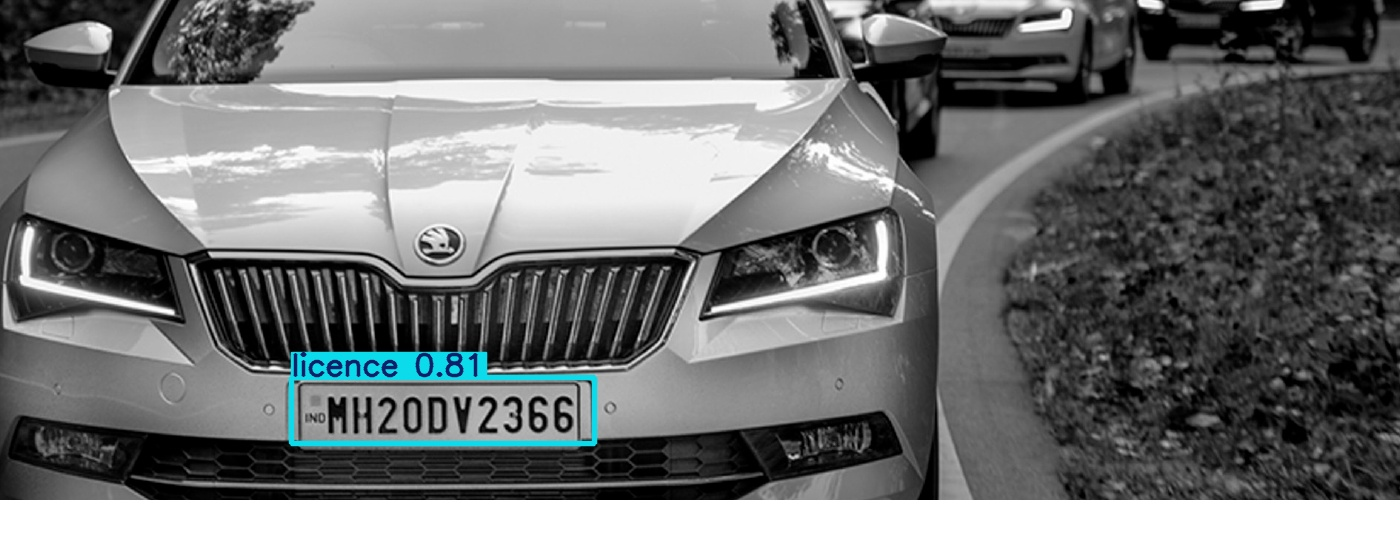

In [ ]:
from PIL import Image
Image.open("runs/detect/predict3/car1.jpg")


In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")
results = model("car1.png", conf=0.4)

img = cv2.imread("car1.png")

plate_img = None

for r in results:
    for box in r.boxes:
        cls_id = int(box.cls[0])
        cls_name = r.names[cls_id]

        if cls_name == "licence":
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            plate_img = img[y1:y2, x1:x2]



image 1/1 /content/car1.png: 256x640 1 licence, 6.3ms
Speed: 1.5ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 640)


(np.float64(-0.5), np.float64(302.5), np.float64(65.5), np.float64(-0.5))

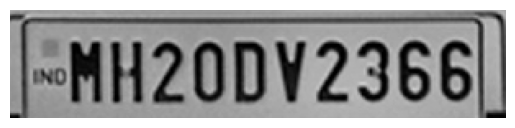

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
plt.axis("off")


In [ ]:
import easyocr
print("EasyOCR installed successfully")


EasyOCR installed successfully


In [ ]:
import cv2
import easyocr
import numpy as np

reader = easyocr.Reader(['en'])

# Convert to grayscale
gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

# Resize more for small plates
gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

# Sharpen image
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
sharp = cv2.filter2D(gray, -1, kernel)

# Try two threshold versions
_, thresh1 = cv2.threshold(sharp, 150, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(sharp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

best_text = ""
best_conf = 0

for img_version in [sharp, thresh1, thresh2]:

    result = reader.readtext(
        img_version,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
        paragraph=False,
        detail=1
    )

    full_text = ""
    confs = []

    for (_, text, prob) in result:
        full_text += text
        confs.append(prob)

    if confs:
        avg_conf = sum(confs) / len(confs)

        if avg_conf > best_conf:
            best_conf = avg_conf
            best_text = full_text

print("Final Plate:", best_text)
print("Confidence:", best_conf)


Final Plate: IXOMHZODV2366
Confidence: 0.6180010810928849


In [ ]:
import re

text = "INDMH20DV2366"

pattern = r'[A-Z]{2}[0-9]{2}[A-Z]{1,3}[0-9]{4}'
match = re.search(pattern, text)

if match:
    print(match.group())


MH20DV2366


In [ ]:
import re
plate_text = re.sub(r'[^A-Z0-9]', '', plate_text)

In [ ]:
import re

def clean_plate(text):
    text = text.replace(" ", "").upper()
    match = re.findall(r'[A-Z0-9]{8,12}', text)
    return match[0] if match else text

print("Final Plate:", clean_plate("MHZODV2366"))


Final Plate: MHZODV2366
